In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import string 
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv


In [2]:
df=pd.read_csv('/kaggle/input/spam-or-not-spam-dataset/spam_or_not_spam.csv')
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [3]:
df.shape

(3000, 2)

In [4]:
df['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

In [5]:
df.isnull().sum()

email    1
label    0
dtype: int64

In [6]:
df=df.dropna()
df.isnull().sum()

email    0
label    0
dtype: int64

In [7]:
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [8]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [9]:
re.sub(r'[^a-zA-Z]',' ','sdf')

'sdf'

In [10]:
from nltk.corpus import stopwords
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  # <-- Required for lemmatization

# Initialize
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Clean function
def clean_sentence(email):
    email=re.sub(r'[^a-zA-Z]',' ',email)
    processed_list = [
        lemmatizer.lemmatize(word).lower()
        for word in word_tokenize(email) 
        if word.lower() not in stop_words
    ]
    join_email = ' '.join(processed_list)
    return join_email

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
df['email']=df['email'].map(clean_sentence)
df.head()

,email,label
0,date wed number aug number number number numbe...,0
1,martin posted tasso papadopoulos greek sculpto...,0
2,man threatens explosion moscow thursday august...,0
3,klez virus die already prolific virus ever kle...,0
4,adding cream spaghetti carbonara effect pasta ...,0


In [12]:
max_words = 10000
cv = CountVectorizer(max_features=max_words, stop_words='english')
sparse_matrix = cv.fit_transform(df['email']).toarray()

In [13]:
print(sparse_matrix[0])

[0 0 0 ... 0 0 0]


In [14]:
sparse_matrix.shape

(2999, 10000)

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(df['label']))


In [16]:
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier  
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report


In [17]:
def train_model(model, model_name):
    print(f'Model: {model_name}')
    
    # Fit the model on the training data
    model.fit(x_train, y_train)
    
    # Predictions on the training data
    y_train_pred = model.predict(x_train)
    # Predictions on the testing data
    y_test_pred = model.predict(x_test)
    
    # Calculate accuracy scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f'Training Accuracy Score: {train_accuracy:.2f}')
    print(f'Testing Accuracy Score: {test_accuracy:.2f}')
    
    # Generate classification report for testing data
    report = classification_report(y_test, y_test_pred)
    print('Classification Report:')
    print(report)
    
    return model

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a dictionary for the models
model_list = dict(
    knn=KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2),
    svc=SVC(kernel='linear', random_state=0),
    logistic=LogisticRegression(),
    naive=GaussianNB(),
    tree=DecisionTreeClassifier(criterion='entropy', random_state=0),
    forest=RandomForestClassifier(n_estimators=50, criterion="entropy"),
    xgboost=XGBClassifier(),
    gradientboost=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1)
)

# Store evaluation results in a list
results = []

# Assuming X_train, y_train, X_test, y_test are already defined
for key, model in model_list.items():
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions
    y_pred = model.predict(x_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Store the metrics in the results list
    results.append({
        'Model': key,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

model_metrics_df = pd.DataFrame(results)


sorted_df = model_metrics_df.sort_values(by='Accuracy', ascending=False)

styled_df = sorted_df.style.background_gradient(cmap='viridis', subset=['Accuracy'])

styled_df

,Model,Accuracy,Precision,Recall,F1-Score
1,svc,0.982667,0.989715,0.950382,0.968700
2,logistic,0.982667,0.986310,0.953391,0.968899
6,xgboost,0.974667,0.977972,0.933499,0.953957
5,forest,0.965333,0.955533,0.921827,0.937600
7,gradientboost,0.956000,0.945258,0.898118,0.919506
3,naive,0.944000,0.958806,0.845713,0.889792
4,tree,0.929333,0.871253,0.890990,0.880652
0,knn,0.881333,0.798635,0.774649,0.785714


In [19]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # 'long' for classification
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [20]:
X_train_tensor.shape

torch.Size([2249, 10000])

In [21]:
y_train_tensor.shape

torch.Size([2249])

In [22]:
class ANN(nn.Module):


    def __init__(self,input_dim):
        super(ANN,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8,1),
            nn.Sigmoid()

        )

    def forward(self,x):
        return self.model(x)

In [23]:
x_train.shape

(2249, 10000)

In [24]:
model = ANN(input_dim=x_train.shape[1])
criterion = nn.BCELoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
epochs = 150
errors=[]

for epoch in range(epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    errors.append([epoch+1, loss])
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [50/150], Loss: 0.0767
Epoch [100/150], Loss: 0.0055
Epoch [150/150], Loss: 0.0023


In [26]:
epochs_list, loss_values = zip(*errors)
loss_values=torch.tensor(loss_values).numpy()

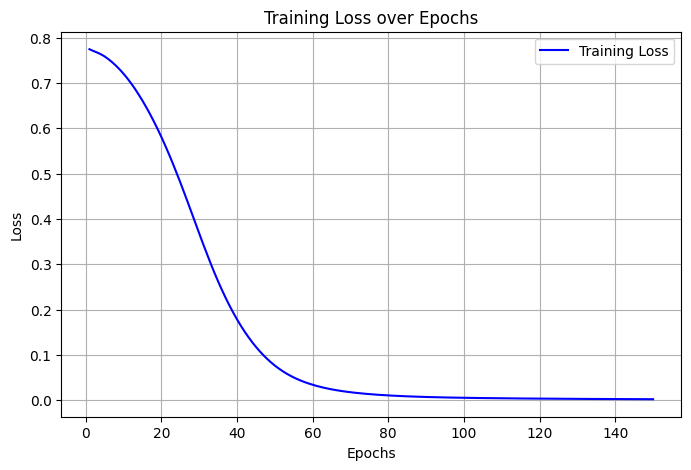

In [27]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, loss_values, label='Training Loss', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

Train Accuracy: 0.9991
Test Accuracy: 0.9747


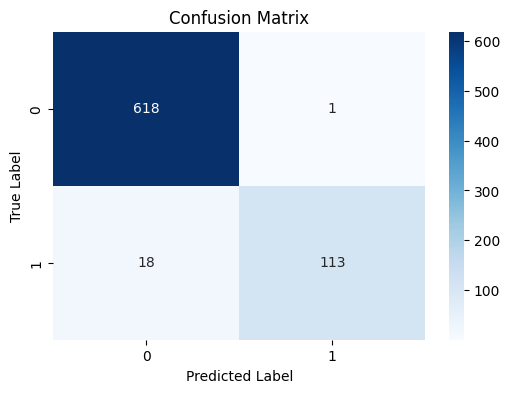

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98       619
     Class 1       0.99      0.86      0.92       131

    accuracy                           0.97       750
   macro avg       0.98      0.93      0.95       750
weighted avg       0.98      0.97      0.97       750

Test Loss: 0.4157


In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    # Get predictions for training and test data
    y_train_pred = model(X_train_tensor)
    y_test_pred = model(X_test_tensor)

    # Apply threshold to get binary class predictions
    y_train_pred_class = (y_train_pred >= 0.5).int()
    y_test_pred_class = (y_test_pred >= 0.5).int()

    # Convert predictions and true labels to numpy
    y_train_pred_class_np = y_train_pred_class.numpy()
    y_test_pred_class_np = y_test_pred_class.numpy()

    y_train_np = y_train_tensor.numpy()
    y_test_np = y_test_tensor.numpy()

    # Accuracy
    train_accuracy = accuracy_score(y_train_np, y_train_pred_class_np)
    test_accuracy = accuracy_score(y_test_np, y_test_pred_class_np)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test_np, y_test_pred_class_np)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("Classification Report:\n", classification_report(y_test_np, y_test_pred_class_np, target_names=["Class 0", "Class 1"]))

    # Test loss
    y_test_tensor = y_test_tensor.float().unsqueeze(1)
    test_loss = criterion(y_test_pred, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")